### Import Packages

In [362]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
from collections import Counter
from IPython.display import clear_output

### Create Necessary Functions

In [363]:
def softmax(z, extra_param = None):
    sums = np.sum(np.exp(z))
    return np.exp(z) / sums

def one_hot(y, total_cats = None):
    if total_cats == None:
        y_onehot = np.zeros([len(y), len(np.unique(y))])
    else:
        y_onehot = np.zeros([len(y), total_cats])

    for i in range(len(y)):
        y_onehot[i, y[i]] = 1
        
    return y_onehot

### Create RNN Class

In [455]:
class RNN():
    
    def __init__(self, input_dim, hidden_dim, bptt_truncate = 4):
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        
        self.U = np.random.uniform(-1 / np.sqrt(self.input_dim), 1 / np.sqrt(self.input_dim),
                                   [self.hidden_dim, self.input_dim])
        self.V = np.random.uniform(-1 / np.sqrt(self.hidden_dim), 1 / np.sqrt(self.hidden_dim),
                                   [self.input_dim, self.hidden_dim])
        self.W = np.random.uniform(-1 / np.sqrt(self.hidden_dim), 1 / np.sqrt(self.hidden_dim),
                                   [self.hidden_dim, self.hidden_dim])
    
    def forward_propagation(self, X):
        # Total number of time steps
        T = X.shape[0]

        # Matrix to hold the hidden state at each step from 0 to T
        S = np.zeros([T + 1, self.hidden_dim])
        # Initialize to zero
        S[-1, :] = np.zeros([self.hidden_dim])
        
        # Matrix to hold output at each time step
        O = np.zeros([T, self.input_dim])
        
        for t in range(T):
            S[t, :] = np.tanh(np.dot(self.U, X[t, :]) + np.dot(self.W, S[t - 1, :]))
            O[t, :] = softmax(np.dot(self.V, S[t, :]))
        return (O, S)
    
    def predict(self, X):
        O, S = self.forward_propagation(X)
        return np.argmax(O, axis = 1)
    
    def calc_total_loss(self, X, y):
        O, S = self.forward_propagation(X)
        return -1 * np.sum(np.log(np.sum(y * O, axis = 1))) / X.shape[0]
    
    def random_loss(self):
        return np.log(self.input_dim)
    
    def bptt(self, X, y):
        T = X.shape[0]
        
        O, S = self.forward_propagation(X)
        
        dL_dU = np.zeros(self.U.shape)
        dL_dV = np.zeros(self.V.shape)
        dL_dW = np.zeros(self.W.shape)
        
        for t in range(T):
            
            a_t = np.dot((O - y)[t, :], self.V) * (1 - S[t, :] ** 2)

            for step in range(t, max(t - self.bptt_truncate, -1), -1):
                
                dL_dU += np.outer(a_t, X[step, :])
                dL_dW += np.outer(a_t, S[step, :])
                a_t = np.dot(a_t, self.W) * (1 - S[step - 1, :] ** 2)
            
            dL_dV += np.outer((O - y)[t, :], S[t, :])
            
        return (dL_dU, dL_dV, dL_dW)
    
    def sgd_step(self, X, y, lr, eta):
        (dL_dU, dL_dV, dL_dW) = self.bptt(X, y)
        
        # Gradient Clipping
        if np.linalg.norm(dL_dU) > eta:
            dL_dU = dL_dU * eta / np.linalg.norm(dL_dU)
        if np.linalg.norm(dL_dV) > eta:
            dL_dV = dL_dV * eta / np.linalg.norm(dL_dV)
        if np.linalg.norm(dL_dW) > eta:
            dL_dW = dL_dW * eta / np.linalg.norm(dL_dW)
            
        self.U = self.U - lr * dL_dU
        self.V = self.V - lr * dL_dV
        self.W = self.W - lr * dL_dW

### Create Dataset

In [469]:
# X is an array with the number of all words on columns, and the sequence of words on rows



alice = list(gutenberg.words('carroll-alice.txt'))[200:400]
alice = [word.lower() for word in alice]
alice_counter = Counter(alice)

num_words = len(alice_counter.most_common())
word_idxs = {alice_counter.most_common()[i][0]: i for i in range(len(alice_counter.most_common()))}

# print(word_idxs)
    
vocabulary = [word for word in word_idxs.keys()]
X = [word_idxs[word] for word in alice]
X = one_hot(X)

### Train Model

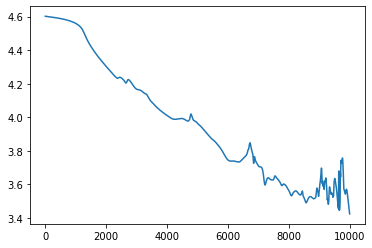

Iteration: 9999 - Current Loss: 3.4238592750912487
['waistcoat', '-', 'pocket', ',', 'and']
['it', ',', ',', 'and', 'then']


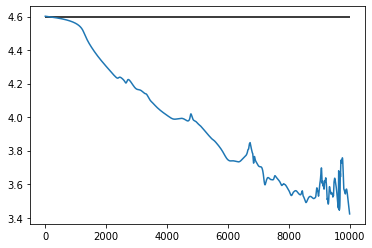

In [487]:
rnn = RNN(X.shape[1], 64, 4)
losses = []

for i in range(10000):
    if i % 10 == 9:
        clear_output()
        plt.plot(losses)
        plt.show()
        print('Iteration: ' + str(i) + ' - Current Loss: ' + str(losses[-1]))
    rnn.sgd_step(X[0:X.shape[0] - 1, :], X[1:X.shape[0], :], .0005, 2)
    losses.append(rnn.calc_total_loss(X, X))
    

print([val for val in alice[30:35]])
output = rnn.predict(X[30:35, :])
print([vocabulary[val] for val in output])

plt.plot(losses)
plt.hlines(y = rnn.random_loss(), xmin = 0, xmax = len(losses))

### Generate Text From Trained Model

In [491]:
seed = ['alice']

for i in range(20):
    seed_idx = [word_idxs[word] for word in seed]
    seed_X = one_hot(seed_idx, len(vocabulary))

    output = [vocabulary[val] for val in rnn.predict(seed_X)]
    seed.append(output[-1])
seed

['alice',
 'had',
 'a',
 'watch',
 'to',
 'to',
 'think',
 'wondered',
 ',',
 'or',
 'at',
 'with',
 'with',
 ',',
 'or',
 'a',
 'to',
 'to',
 'wondered',
 'out',
 'of']